In [213]:
import matplotlib.pyplot as plt
import importlib
import bitmap_editor
importlib.reload(bitmap_editor)
import numpy as np

height = 50
width = 50
bitmap_matrix = np.zeros(shape=(height,width))
bitmapEditor = bitmap_editor.BitmapEditor(bitmap_matrix)

Canvas(width=500)

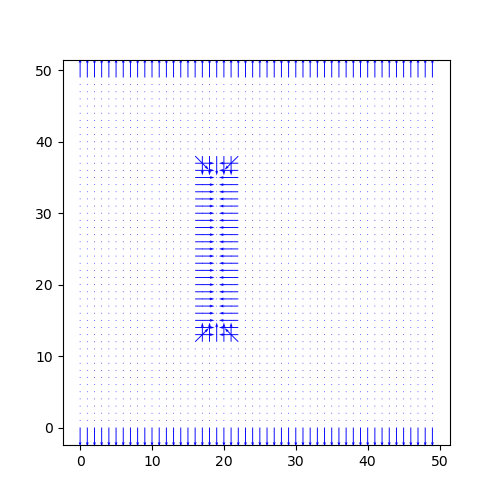

In [208]:
import navier_stokes
importlib.reload(navier_stokes)

grid = np.flip(np.copy(bitmap_matrix), 0)

######### Actual simulation code

fluid_cells = navier_stokes.fluid_cells(grid, inward_corner_difference=True, simple_normals=True)
fluid_cell_index = navier_stokes.fluid_cell_index(fluid_cells, grid.shape)

# navier_stokes.simplify_normals(fluid_cells)

A = navier_stokes.projection_A(fluid_cells, fluid_cell_index, grid.shape[1])
b = navier_stokes.projection_b(fluid_cells)

################
X, Y = np.meshgrid(np.arange(width), np.arange(height))
NormalsU = np.zeros(shape=(height, width))
NormalsV = np.zeros(shape=(height, width))

for fluid_cell in fluid_cells:
    normal = np.array([0, 0])
    if fluid_cell.boundary_normal is not None:
        normal = fluid_cell.boundary_normal
    NormalsU[fluid_cell.grid_index] = normal[0]
    NormalsV[fluid_cell.grid_index] = normal[1]


%matplotlib widget
fig, ax = plt.subplots(figsize=(5, 5))
ax.quiver(X, Y, NormalsU, NormalsV, color="b", scale=20)
plt.show()

In [ ]:

with np.printoptions(threshold=np.inf):
    print(A)

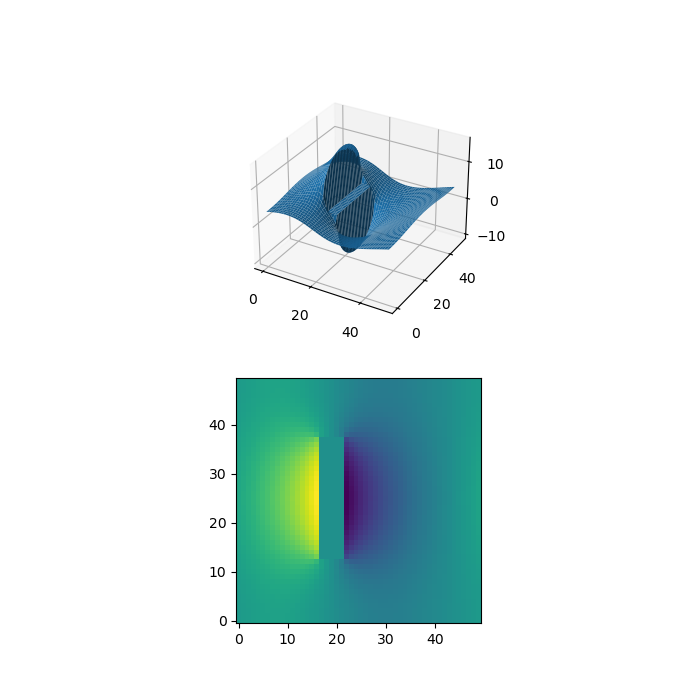

In [212]:
%matplotlib widget
import pyamg

# ml = pyamg.ruge_stuben_solver(A)  # Build the multigrid hierarchy
# residuals = []
# x = ml.solve(b, tol=1e-8, maxiter=1000, residuals=residuals)
# print(len(residuals))
# print(residuals[-1])
x = np.linalg.solve(A,b)

mesh = np.zeros(shape=(height,width))

avg = np.average(x)

for j in range(0,height):
    for i in range(0,width):
        if grid[j][i]:
            mesh[j][i] = avg
            continue
        index = fluid_cell_index[j][i]
        mesh[j][i] = x[index]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(211, projection='3d')
ax2 = fig.add_subplot(212)
ax2.imshow(mesh, interpolation='none', origin='lower')

# plt.imshow(mesh, interpolation='none', origin='lower')
ax.plot_surface(X,Y,mesh) 
plt.show()

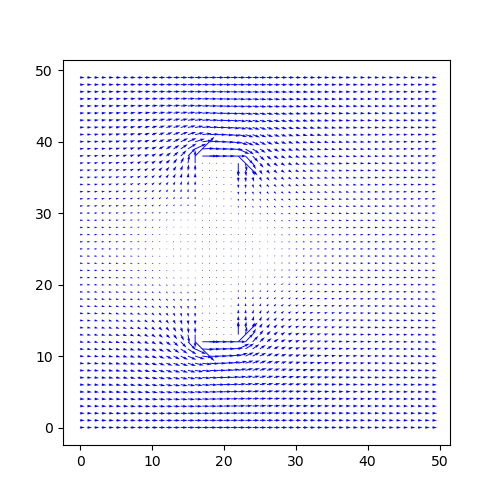

In [211]:
U = np.zeros(shape=mesh.shape)
V = np.zeros(shape=mesh.shape)

for fluid_cell in fluid_cells:
    xa = fluid_cells[fluid_cell.x_diff[0]].grid_index
    xb = fluid_cells[fluid_cell.x_diff[1]].grid_index
    xd = fluid_cell.x_diff[2]
    U[fluid_cell.grid_index] = (mesh[xa] - mesh[xb])/xd

    ya = fluid_cells[fluid_cell.y_diff[0]].grid_index
    yb = fluid_cells[fluid_cell.y_diff[1]].grid_index
    yd = fluid_cell.y_diff[2]
    V[fluid_cell.grid_index] = (mesh[ya] - mesh[yb])/yd

newU = 1-U
for j,i in np.ndindex(mesh.shape):
    if grid[j][i]:
        newU[j][i]=0


fig, ax = plt.subplots(figsize=(5, 5))
ax.quiver(X, Y, newU, -V, color="b")
# ax.quiver(X, Y, U, V, color="b")
plt.show()

# ax3.quiver(X,Y, 2-U, -V)

In [ ]:
A = np.array([[0,0,1], [0,0,0], [0,0,0]])

print(np.array((1,1)))
# print(len(A))
# obstacle_indices = (np.array(np.where(A == 1)).T - np.array([1,1])).tolist()

obstacle_indices = [(j-1,i-1) for j in range(3) for i in range(3) if A[j][i]]

# print(obstacle_indices)
# print(obstacle_indices)
# print([-1, 1] in obstacle_indices)

# print(np.array([1,1]) == np.abs(np.array([-1,1])))

# corner = np.abs(obstacle_indices[0]) == np.array([1,1])
# print(corner)
# print(np.abs(obstacle_indices[0]) == 
# if ():
#     print('corner')
# np.any([A[i]>8 for i in [(1,1),(2,2),(0,0)]])